# eBeam Lithography simulation using PSF from Casino3
##  *Part 1: Exposure*

In this first demo I use a PSF function to expose a demo pattern.

The Casino3 software can be downloaded here http://www.gel.usherbrooke.ca/casino/. You have to register to download

The demo sample is a 300nm ZEP520A resist layer on a silicon substrate. For this example I use 1e7 electrons with 30kV of accelerate voltage and the options are: 
 - no generate secondary electrons, 
 - 1nm beam diameter, 
 - 100 mrad beam semi-angle
 - 1.65 gaussian beam distribution.
 - cartesian distribution for data
 - ...
 
more parameters are in the sample file 'ZEP520A300_Si.sim' given with this demo.

The PSF is saved in *zep520_1e7_30kV_100mrad_1pt* file. This file will be used in this example.

First, let's import some libraries:

### Import libraries

In [1]:
%matplotlib notebook

import os, sys, math, string
from sympy.ntheory import primefactors, factorint
from timeit import default_timer as timer #for timing

import numpy as np
from scipy.constants import e #in Coulomb
#from scipy.interpolate import interp1d

import matplotlib.pyplot as plt #for plotting

import imageio

#for CUDA:
from numba import cuda
from numba import * #I don't know why I have to split the cell here when I import all the lib *!
#continue to cell below...

In [2]:
#...from cell above
from __future__ import print_function

import pycuda.autoinit
import pycuda.driver as cudadriver
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

#for using FFT with scikitcuda:
import skcuda.fft as cu_fft
import skcuda.linalg as linalg

# lib written by me:
os.chdir('../')
import PatternGenerator as pg
from Casino import Casino3 as cs3

/home/looninho/anaconda3/envs/cudaenv_py37/lib/python3.6/site-packages/scikit_cuda-0.5.3-py3.6.egg/skcuda/cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [3]:
# some usefull functions written by me

## getting probe current on Zeiss Supra 40 SEM
### beam current (pA) at largest aperture for 30, 20, 10 and 5 kV:
MAX_CURRENT_30 = 7300 
MAX_CURRENT_20 = 4340
MAX_CURRENT_10 = 2750
MAX_CURRENT_5 = 2000

# below these two functions are for a typical SEM Zeiss Supra 40:
def getpc(kV, maxpc,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    maxpc : beam current at biggest aperture (pA).
    ap : list of aperture diameters (µm).
    example : getpc(30,7300) return an array of beam currents for different aperture sizes.'''
    im = len(ap)-2
    pc=np.array([maxpc]*(im+2))
    for ii in np.arange(im,-1,-1):
        pc[ii] = pc[ii+1]*(ap[ii]/ap[ii+1])**2
    return pc

def getpc2(kV, pci,i,ap=[7.5,10,20,30,60,120]):
    '''kV : high voltage used (kV).
    pci : beam current (pA) at ith aperture. i=0 is the smallest aperture.
    ap : list of aperture diameters (µm).
    example : getpc(30,456,3) return an array of beam currents for different aperture sizes.'''
    assert i >= 0 and i < len(ap)
    pc=np.array([0]*len(ap))
    pc[i] = pci
    pc[-1] = pc[i]*(ap[-1]/ap[i])**2
    for ii2 in np.arange(len(ap)-2,-1,-1):
        pc[ii2] = pc[ii2+1]*(ap[ii2]/ap[ii2+1])**2
    return pc

In [4]:
## for kernel use:
def i2f(idx,WF,px_size):
    '''It is the reverse function of float2idx.'''
    return -WF/2+idx*px_size

def f2i(x,WF,px_size):
    '''It just converts a float value to index integer in the array of WF.'''
    return int((x+WF/2)/px_size)

f2i_gpu = cuda.jit(device=True)(f2i)

@cuda.jit
def pattern2matrix(dest, pattern, WF, pxs):
    '''Map the pattern to matrix data.
    It will also correct redundance dots in pattern.'''
    i = cuda.grid(1)
    ix = f2i_gpu(pattern[i,0],WF,pxs)
    iy = f2i_gpu(pattern[i,1],WF,pxs)
    dest[ix,iy] += pattern[i,2]

def psf_interp1(r,sr,M,data):
    '''You don't need to use this function.
    It's a subroutine for kernel to interpolate points in beetwen two simulated data.'''
    r_i = r/sr
    i_lo=int(r_i);i_hi = i_lo+1 if r_i > i_lo else i_lo
    if i_hi >= M:
        return 0.0
    elif i_hi == i_lo:
        return data[i_hi,1]
    else:
        slope = (data[i_hi,1]-data[i_lo,1])/(data[i_hi,0]-data[i_lo,0])
        return slope*(r-data[i_lo,0]) + data[i_lo,1]

psf_interp1_gpu = cuda.jit(device=True)(psf_interp1)

@cuda.jit
def psf_kernel(psf,point,NP,WF,pixel_size,sr,nr,simdata):
    '''This kernel stores the PSF function in the psf 2D-array.
    point: only a dot at (x=0,y=0,dose=1) the center of the writefield (WF).
    NP: number of pixel in one dimension of WF. Here we work on a square 2D-array.
    for saving the GPU time, I think it's better to give the size of the pixel instead of letting the kernel calculate it.
    sr, nr are the step and the number of points respectivly in the electron-range direction of the simulated data, simdata.
    simdata: simulated data by Casino. its shape is two columns: one for x and one for y (the deposited energy at point x).
    '''
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y
    for x in range(startX, NP, gridX):
        val_x = -WF/2 + x*pixel_size
        for y in range(startY, NP, gridY):
            val_y = -WF/2 + y*pixel_size
            r = math.sqrt((val_x-point[0])**2+(val_y-point[1])**2)
            psf[y, x] += point[2]*psf_interp1_gpu(r,sr,nr,simdata)

In [5]:
## Miscellaneous:
def idx2val(simdata,idx=0,axis=2):
    '''ouput the value belong to axis (0=x; 1=y; 2=z).
    use case: idx2val(sim.data,3,2).'''
    assert isinstance(simdata,np.ndarray)
    assert isinstance(idx, int)
    assert isinstance(axis, int)
    assert axis < 3 and axis >=0
    if len(simdata.shape) != 3:
        print("not a 3D-data!")
        return
    if idx >= simdata.shape[axis]:
        print("index out of range")
        return
    else:
        if axis == 0:
            return sim.xrange[0]+idx*sim.sx
        elif axis == 1:
            return sim.yrange[0]+idx*sim.sy
        else:
            return sim.zrange[0]+idx*sim.sz

def dtfactor(dose,step_size,current,speed=6):
    '''return the dwelltime factor (dt/dt0).
    dose in µC/cm²; step_size in nm; current in pA and speed in MHz.'''
    return speed*step_size**2*dose/current/100

def mylocalplot(z,xc,yc,WF,swf,pxs):
    assert swf <= WF
    if xc > ((WF-swf)/2):
        xc = (WF-swf)/2
    if xc < ((swf-WF)/2):
        xc = (swf-WF)/2
    if yc > ((WF-swf)/2):
        yc = (WF-swf)/2
    if yc < ((swf-WF)/2):
        yc = (swf-WF)/2
    ix=f2i(yc,WF,pxs)
    iy=f2i(xc,WF,pxs)
    ni=int(swf/pxs)-1
    plt.imshow(z[ix-ni//2:ix+ni//2,iy-ni//2:iy+ni//2],origin='lower', extent=[xc-swf/2, xc+swf/2, yc-swf/2, yc+swf/2],interpolation="nearest", cmap=plt.cm.jet)
    plt.show()
    return

### Create a demo pattern : photonic crystal
Now we create a photonic crystal pattern with size = 4000 nm; radius = 48 nm; spacing = 170 nm and step_size= 4 nm.
The pattern is generated by *PatternGenerator.py*.

In [6]:
# create PhCs_Orsay sites:
radius=48.0;a=170.0;ss=4
start = timer()
site_points=pg.PCsPattern2(a)
local_pattern=pg.circPattern(0,0,radius,ss)

print(site_points.shape)

i=0
# search dot's index and remove dot at (0,0):
while  not np.allclose(site_points[i], [0.0,0.0], atol=1e-3):
    i += 1

print(i)

site_points=np.delete(site_points,i,0)
print(site_points.shape)

#the final pattern is the convolution of local pattern and site points:
final_pattern=pg.replacePointsByPattern(site_points,local_pattern)
dt = timer() - start
print("total {} points created in {} s".format(final_pattern.shape[0], dt))

(672, 2)
313
(671, 2)
total 275110 points created in 0.9854505499997686 s


Hereafter is the plot of the photonic crystal's sites:

<IPython.core.display.Javascript object>


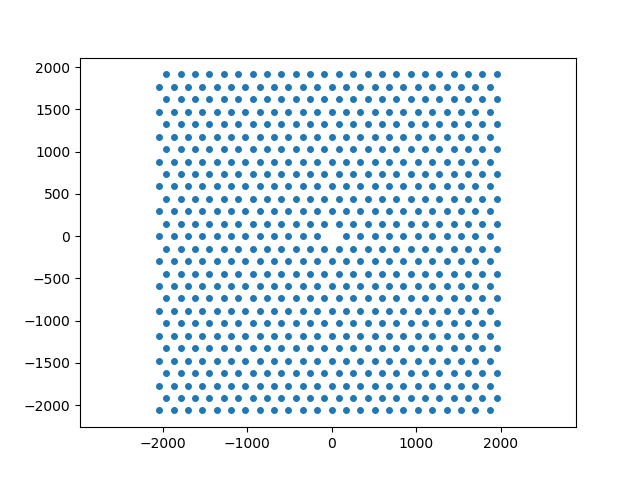

In [7]:
plt.plot(site_points[:,0], site_points[:,1], 'o', ms=4)
plt.axis('equal');plt.show()

At each site we will place a circle pattern:

<IPython.core.display.Javascript object>


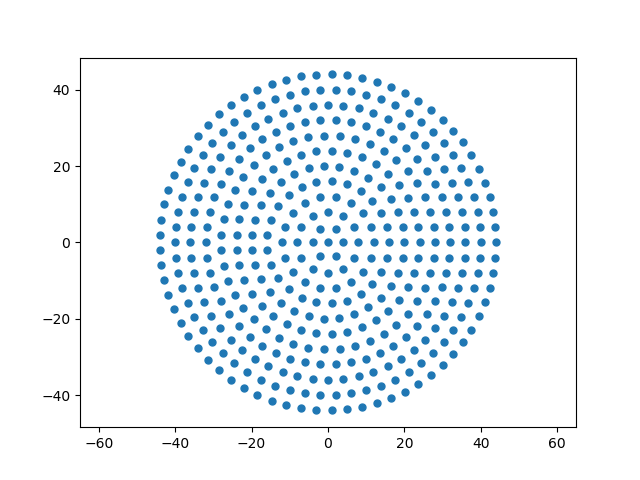

In [8]:
plt.plot(local_pattern[:,0], local_pattern[:,1], 'o', ms=5)
plt.axis('equal');plt.show()

The final pattern is a photonic crystal showed below:

<IPython.core.display.Javascript object>


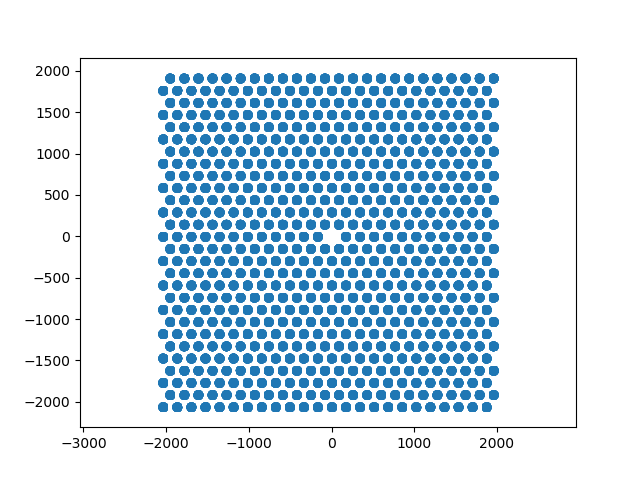

In [9]:
plt.plot(final_pattern[:,0], final_pattern[:,1], 'o', ms=1)
plt.axis('equal');plt.show()

### Import PSF data from Casino3 simulation:
- Hereafter we calculate the normalization factor for a simulated 1e7 electron paths.
- Then we import the result from Monte-Carlo simulation by Casino3 saved in *zep520_1e7_30kV_100mrad_1pt* file.
- For this demo we simulate at the middle thickness of the resist (zi=3) and we use the smallest beam current (*normalizeFactors[0]*).

In [7]:
#SEM + EBL parameters:
Nesim=1e7 #number of simulated electron paths. Must be the same as in Casino3 software simulation parameters.
PGSpeed=6e6 #pattern generator (Raith Elphy Plus) max frequency in Hz

#semCurrentsAt30kV=np.array([24,48,196,411,1780,7300])*1e-12 #SEM currents tab in Ampere at 30 kV
semCurrentsAtkV=getpc(30,MAX_CURRENT_30)*1e-12 #SEM currents tab in Ampere at 30 kV

minimalDoses=semCurrentsAtkV/PGSpeed #in C
Nelectrons=minimalDoses/e
normalizeFactors=Nelectrons/Nesim

# import data from cs3:
os.chdir('demo')
filename='zep520_1e7_30kV_100mrad_1pt'
sim=cs3(filename)

# create electron range array for X-axis:
r= np.arange(sim.xrange[0],sim.xrange[1],sim.sx)

# create XY array (for the smallest beam current multiply y-values by normalizeFactors[0]):
yi=3;zi=3 #half thickness of resist (150 nm)
mcdata=np.c_[r,1000*sim.data[:,yi,zi]*normalizeFactors[0]] #TODO check with casino3 authors (M. Dominique Drouin,...) that the unit is in keV so *1000 to get eV

<IPython.core.display.Javascript object>


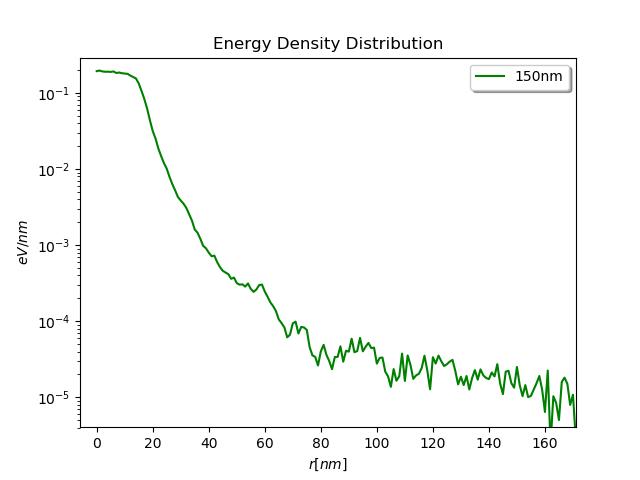

min value = 0.0; mean value = 0.00041776306779262853; max value = 0.19654753575759243.


In [30]:
#let's see what look-like the PSF at 150 nm depth of the ebeam resist:
plt.semilogy(mcdata[:,0],mcdata[:,1],'g-',label='150nm')
plt.title('Energy Density Distribution');plt.xlabel('$r[nm]$');plt.ylabel('$eV/nm$'); plt.legend(loc='upper right', shadow=True)
plt.show()

# print the min, max  and mean values:
log_message = f'min value = {np.min(mcdata[:,1])}; mean value = {np.mean(mcdata[:,1])}; max value = {np.max(mcdata[:,1])}.'
print(log_message)

# keep only values > 0:
#mcdata[:,1] = (mcdata[:,1]>0) * mcdata[:,1]
#print(np.min(mcdata[:,1]), np.max(mcdata[:,1]),np.mean(mcdata[:,1]))

### "See" the electron range radius $R_0$ (stopping power):
$R_0$ : look in x-axis of the PSF curve and find with psf_interp1 function where there is no more energy density.
This is for information, not used in this demo.

In [8]:
#R0=7700;psf_interp1(R0,sim.sr,sim.nr,mcdata)
sr=mcdata[1,0]-mcdata[0,0];nr=mcdata.shape[0] #step in r and number of steps
R0=2990;psf_interp1(R0,sr,nr,mcdata) #absorpbed energy at R0 distance from the beam location (r=0nm)

0.0

### Define the pixel size:
So we can calculate the pixel size:

In [9]:
n=4
NP=n*512;WF=5000

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] indices.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))

#print values
NP, ss, pixel_size

(2048, 4, 2.4414062)

### Map the PSF to 2D-array

the size of our 2D-array is NP$^2$

In [10]:
# GPU RAM available before:
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

95.2 % of device memory is free.


- z_psf matrix data is the PSF in 2D-dimension.
- Note : this is related to your probe current with normalizeFactors defined earlier

In [11]:
# "cut" the 2D-array in blocks and grids for parallel computing:
blockdim = (32, 16)
griddim = (int(NP/blockdim[0]),int(NP/blockdim[1]))
z_psf = np.zeros((NP, NP), dtype = np.float64)

# start the timer and transfert data from CPU to GPU:
start = timer()
out_gpu = cuda.to_device(z_psf)
in_gpu = cuda.to_device(mcdata)
    
# call the kernel for mapping PSF to 2D-array:
psf_kernel[griddim, blockdim](out_gpu,pg.dotPattern(0,0)[0],NP,WF,pixel_size,sr,nr,in_gpu) 

# copy the result back to CPU and release GPU memory:
out_gpu.to_host()
in_gpu.to_host()

#stop the timer and print the min, max values:
dt = timer() - start
print("z_PSF created on GPU in %f s" % dt)
log_message = f'min value = {np.min(z_psf)}; max value = {np.max(z_psf)}; sum value = {np.sum(z_psf)}.'
print(log_message)

# GPU RAM available after:
out_gpu.gpu_data._mem.free()
in_gpu.gpu_data._mem.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

z_PSF created on GPU in 0.377795 s
min value = 0.0; max value = 0.19314753607635882; sum value = 40.4588758013394.
93.5 % of device memory is free.


<IPython.core.display.Javascript object>


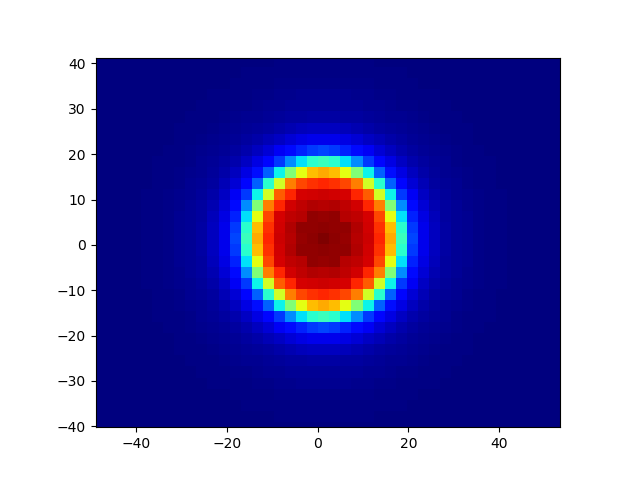

In [11]:
#plot PSF:
plt.imshow(z_psf,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

#### kernel need to be expanded to image (expo) size and padded according to the white paper of Victor Podlozhnyuk

In [12]:
#padded psf for even NP:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

<IPython.core.display.Javascript object>


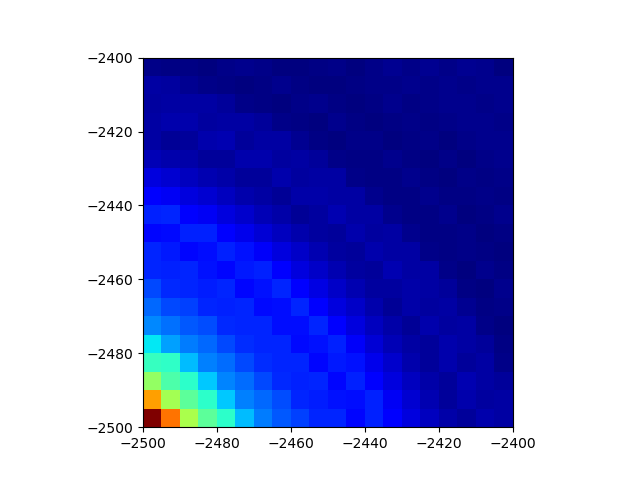

In [40]:
mylocalplot(ppsf,-2450,-2450,WF,100,NP)

### Create dose distribution:
- *dose_dis* is the initial dose distribution for this demo pattern. *Dose factor = 1* at each dot of the pattern.

In [14]:
NP,WF,final_pattern.shape,final_pattern[:,2].sum()

(2048, 5000, (275781, 3), 275781.0)

In [15]:
factorint(final_pattern.shape[0]), primefactors(final_pattern.shape[0])

({3: 1, 11: 1, 61: 1, 137: 1}, [3, 11, 61, 137])

In [16]:
#we cut the final_pattern into grid of blocks size:
11*61,3*137

(671, 411)

In [13]:
#transfert pattern to matrix
blockdim = (671, 1)
griddim = (411,1)
dose_dis = np.zeros((NP, NP), dtype = np.float64)

start = timer()
out_gpu = cuda.to_device(dose_dis)
in_gpu = cuda.to_device(final_pattern)

pattern2matrix[griddim, blockdim](out_gpu,in_gpu,WF,pixel_size)

out_gpu.to_host()
in_gpu.to_host()
dt = timer() - start
print("Dose calculated on GPU in %f s" % dt)
log_message = f'overlap = {dose_dis.sum()-final_pattern[:,2].sum()}. Negative value = lost dose.'
print(log_message)

print(np.max(final_pattern[:,2]),np.max(dose_dis))

out_gpu.gpu_data._mem.free()
in_gpu.gpu_data._mem.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

Dose calculated on GPU in 0.108640 s
overlap = 0.0. Negative value = lost dose.
1.0 1.0
93.1 % of device memory is free.


In [18]:
#remember all the sem currents:
semCurrentsAtkV

array([2.800e-11, 5.000e-11, 2.020e-10, 4.560e-10, 1.825e-09, 7.300e-09])

In [14]:
# Let's exposure at 30 µC/cm²:
dose_dis *= dtfactor(30,ss,28)

<IPython.core.display.Javascript object>


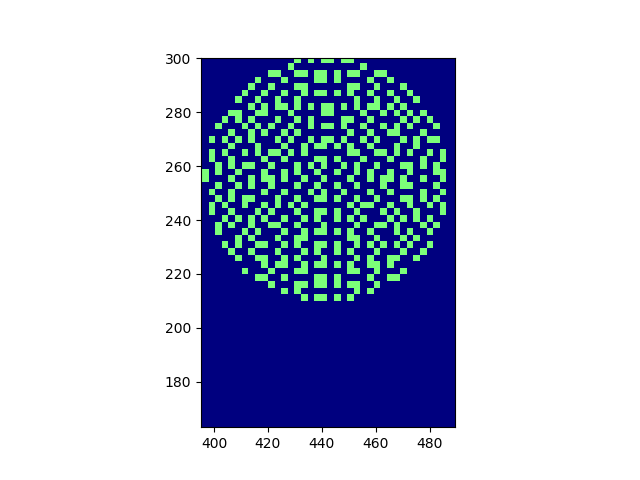

In [203]:
plt.imshow(dose_dis,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

### Simulation of ebeam exposure:
- This is the exposure simulation for this demo pattern
- you can save the result in a file and reload it later saving simultaion time

##### Expo by FFT convolution
Convolution by FFT principe:
 - apply direct FFT to the convolution kernel (padded)
 - apply direct FFT to the input data array (or image)
 - perform the point-wise multiplication of the two preceding results
 - apply inverse FFT to the result of the multiplication


In [15]:
start = timer()
#get [ TF(psf) ] and TF[ dose_dis]
print('GPU : FFT(psf) = psf in-place fft..')
tx = np.asarray(ppsf, np.complex128)
fftpsf_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(fftpsf_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(fftpsf_gpu, fftpsf_gpu, plan)

print('GPU : FFT(dose_pc) = dose_dis in-place fft..')
tx = np.asarray(dose_dis, np.complex128)
out_gpu = gpuarray.to_gpu(tx)
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.fft(out_gpu, out_gpu, plan)

#perform point-wise multiplication
print('GPU : point-wise multiplication of two matrices...')
linalg.init()
out_gpu = linalg.multiply(out_gpu, fftpsf_gpu)

#free fftpsf_gpu:
fftpsf_gpu.gpudata.free()

#apply inverse FFT
print('GPU : inverse FFT to get exposure energy distribution...')
plan = cu_fft.Plan(out_gpu.shape, np.complex128, np.complex128)
cu_fft.ifft(out_gpu, out_gpu, plan, True)
z=out_gpu.get()

dt = timer() - start
print("convolution done on GPU in %f s" % dt)
#winsound.Beep(freq, duration)

free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

out_gpu.gpudata.free()
free, total = cudadriver.mem_get_info()
print ('%.1f %% of device memory is free.' % ((free/float(total))*100))

np.min(z.real),np.min(z.imag),np.max(z.real),np.max(z.imag)


GPU : FFT(psf) = psf in-place fft..
GPU : FFT(dose_pc) = dose_dis in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get exposure energy distribution...
convolution done on GPU in 0.796735 s
89.9 % of device memory is free.
90.4 % of device memory is free.


(0.4839025805337009,
 -6.233028556959162e-15,
 12.714007032633647,
 5.945881336100755e-15)

<IPython.core.display.Javascript object>


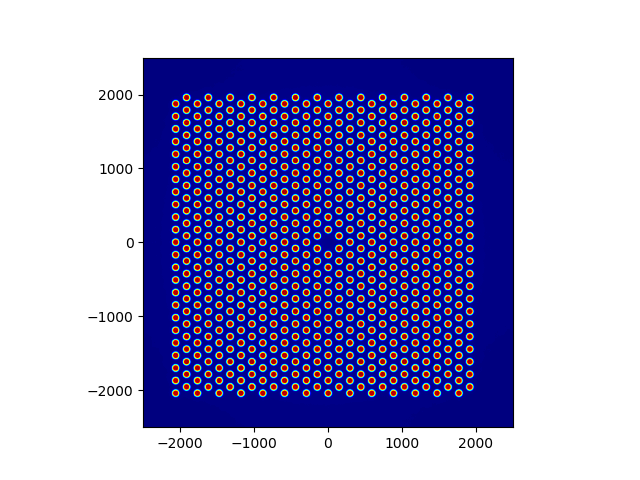

In [21]:
plt.imshow(z.real,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

In [59]:
#for saving or loading data:
filename='PhCs_cs3_30kV_1e7_WF5000_ss4_PC0_2048px'
np.save(filename,z.real)
#z=np.load(filename+'.npy')

### Develop this exposure
- A clearing dose = $12 eV/nm$ match the experimental result

In [16]:
filename='R48_D180_1_50_16p5_th0p012-2.png'
z *= 6 #dose increase 6 times
np.min(z.real),np.mean(z.real), np.max(z.real),np.min(z.imag),np.max(z.imag)

(2.903415483202205,
 16.377438991332745,
 76.28404219580189,
 -3.739817134175497e-14,
 3.567528801660453e-14)

In [17]:
th_resist=12 #clearing dose = 12 eV
z_dev = (z.real> th_resist) * z.real

z_dev[z_dev > 0] = 1

#plt.imshow(z_dev,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

imageio.imwrite(filename, z_dev) #save image to filename

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


#### some plots:

<IPython.core.display.Javascript object>


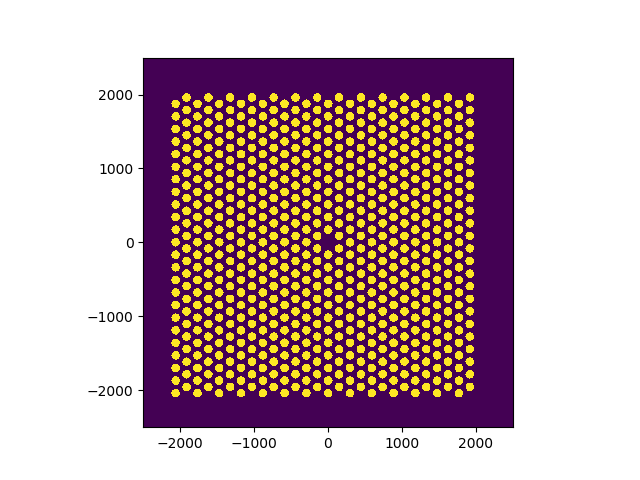

In [18]:
plt.imshow(z_dev,origin='lower', extent=[-WF/2, WF/2, -WF/2, WF/2]);plt.show()

<IPython.core.display.Javascript object>


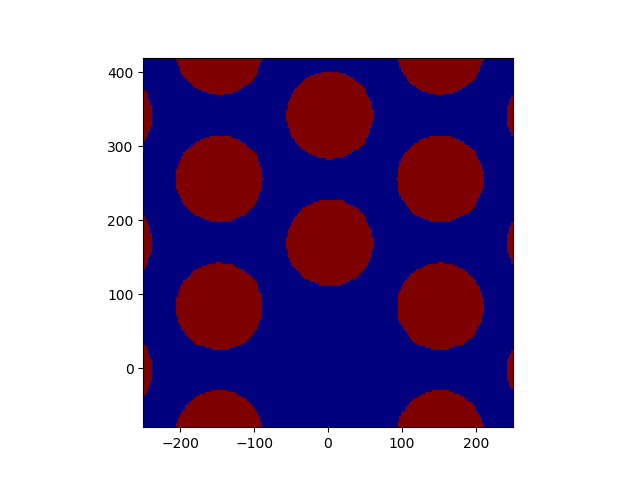

In [27]:
mylocalplot(z_dev,0,170,WF,500,pixel_size)

<IPython.core.display.Javascript object>


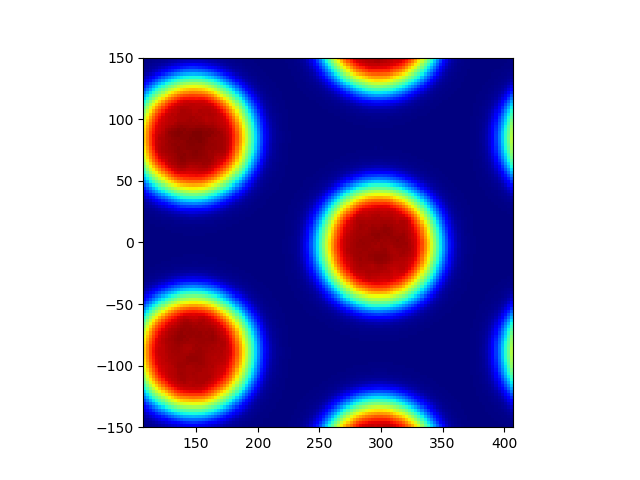

In [28]:
mylocalplot(z.real,257,0,WF,300,pixel_size)

<IPython.core.display.Javascript object>


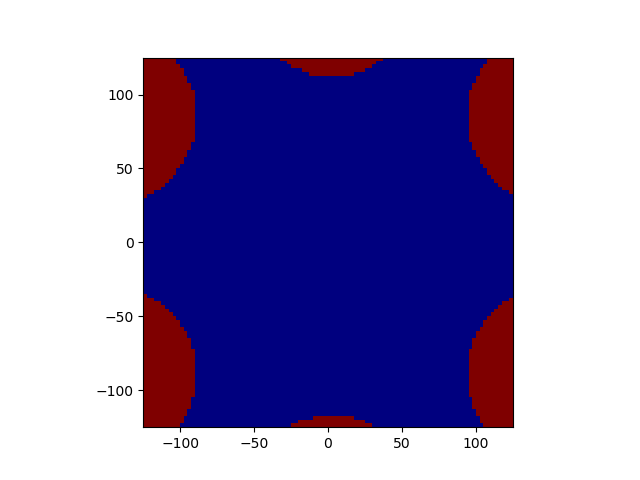

In [29]:
mylocalplot(z_dev,0,0,WF,250,pixel_size)

### 3D view
Use pyopengl and pyqygraph

In [19]:
from pyqtgraph.Qt import QtCore, QtGui
import pyqtgraph as pg
import pyqtgraph.opengl as gl

In [20]:
app = QtGui.QApplication([])

In [21]:
x=np.linspace(-WF/2,WF/2,NP)
y=np.linspace(-WF/2,WF/2,NP)

#3D GL view:
w = gl.GLViewWidget()
w.show()
w.setWindowTitle('Expo EBL: ')
w.setCameraPosition(distance=50)

## Add a grid to the view
g = gl.GLGridItem()
g.scale(1,1,1)
g.setDepthValue(1)  # draw grid after surfaces since they may be translucent
w.addItem(g)

cmap=plt.get_cmap('jet')
minZ=np.min(z.real);maxZ=np.max(z.real)
rgba_img=cmap((z.real-minZ)/(maxZ-minZ))

## Simple surface plot example
p1 = gl.GLSurfacePlotItem(x,y,z.real, colors=rgba_img)
#p1.translate(0, 0, -np.mean(z))
w.addItem(p1)

if (sys.flags.interactive != 1) or not hasattr(QtCore, 'PYQT_VERSION'):
    QtGui.QApplication.instance().exec_()


### Exercice:
Do the expo simulation for all the z-steps in depth of the resist

Tip : change zi in sim.data